# TP - 5: autoencoders

Martín Pasche

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import Progbar

from time import time

import datetime

import sys
import os
import pickle

# only grow GPU memory when needed
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

os.environ['TF_USE_LEGACY_KERAS'] = 'True'


In [2]:
data = pd.read_csv('sp500_20161229.csv.gz', compression='gzip')
data['index'] = pd.to_datetime(data['index'])
data.set_index('index', inplace=True)
print(data.shape)
data.head(3)


(3145, 328)


,A,AA,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,AEP,AES,AET,AIV,ALL,ALTR,AMAT,AMD,AMGN,AMP,AMZN,AN,ANTM,AON,APA,APD,ASH,ATI,AVP,AVY,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BC,BDX,BEN,BIG,BIIB,BK,BLL,BMS,BMY,BSX,BTU,BXP,CA,CAG,CAH,CAT,CB,CBH,CBS,CCE,CCL,CELG,CHK,CI,CIEN,CINF,CL,CLX,CMA,CMCSA,CMI,CMS,CNP,CNX,COF,COL,COP,COST,CPB,CPWR,CSCO,CSX,CTAS,CTL,CTSH,CTXS,CVG,CVS,CVX,D,DDS,DE,DF,DGX,DHI,DHR,DIS,DOV,DRI,DTE,DTV,DUK,DVN,EA,EBAY,ECL,ED,EFX,EIX,EL,EMN,EMR,EOG,EQR,ESRX,ETFC,ETN,ETR,EXC,F,FDC,FDX,FE,FHN,FII,FIS,FISV,FITB,FLR,FMCC,FNMA,FTR,GD,GEC,GILD,GIS,GLW,GNW,GOOGL,GPC,GPS,GS,GT,GWW,HAL,HAS,HBAN,HD,HES,HIG,HLT,HOG,HPQ,HRB,HSY,HUM,IAC,IBM,IFF,IGT,INTU,IP,IPG,IR,ITT,ITW,JBL,JCI,JCP,JNJ,JNPR,JPM,JWN,K,KBH,KEY,KIM,KLAC,KMB,KO,KR,KSS,LEG,LEN,LH,LLL,LLY,LM,LNC,LOW,LSI,LUV,M,MAR,MAS,MAT,MBI,MCD,MCK,MCO,MDP,MDT,MKC,MMC,MMM,MO,MRK,MRO,MS,MSFT,MTG,MTZ,MU,MUR,MXIM,MYL,NBR,NCR,NCRA,NE,NEE,NEM,NI,NKE,NOV,NSC,NTAP,NTRS,NUE,NVDA,NWL,NYT,ODP,OMC,ORCL,OXY,PAYX,PBI,PCAR,PCG,PDCO,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKI,PNC,PNW,PPG,PPL,PSA,PX,R,RDC,RHI,RIG,ROK,RRD,S,SANM,SBUX,SEE,SHLD,SHW,SLM,SNA,SNV,SO,SPG,SRE,SSP,STI,STT,STZ,SUN,SVU,SWK,SYK,SYMC,SYY,T,TAP,TER,TEX,TGNA,TGT,THC,TIF,TJX,TMK,TMO,TROW,TSG,TSN,TXN,TXT,UIS,UNH,UNP,UPS,USB,UTX,VFC,VIAB,VLO,VMC,VNO,VRSN,VZ,WAT,WB,WFT,WHR,WIN,WM,WMB,WMT,WU,WY,XEL,XL,XLNX,XOM,XRX,YUM,ZBH,ZION
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.006308,0.011160,0.044155,0.020773,0.003043,0.049784,0.023139,0.009368,-0.004657,0.012100,0.007280,0.023373,-0.002651,0.022445,0.012206,0.030761,0.021739,0.058824,0.019021,0.026829,0.009120,0.012425,-0.005389,0.036161,0.034734,0.007096,0.034888,-0.000831,-0.009107,0.019179,0.011008,0.001424,0.020152,0.018858,0.006916,0.009544,0.028749,0.003935,0.006158,0.020104,0.014155,0.031105,0.020722,0.012336,0.026552,0.011314,-0.001225,0.045863,0.016592,-0.010997,0.011834,0.017164,0.000519,0.020584,NaN,0.000000,0.005216,0.020572,0.001389,0.039710,0.005372,0.026936,0.004924,0.001094,0.004570,0.014799,0.010401,0.012705,0.002757,0.011673,0.039276,0.006713,0.011620,0.040048,0.009096,0.007726,NaN,0.019276,-0.016151,0.007771,-0.001508,0.006753,0.014941,0.001893,-0.002650,0.040691,0.025389,0.022562,-0.001615,0.010356,-0.002914,0.033865,0.010398,0.017939,0.024697,-0.010031,0.012271,0.018414,0.014208,0.034378,0.019690,0.027977,-0.015715,0.007986,0.012625,0.026599,-0.004182,0.013181,0.005756,0.076325,0.022239,0.036158,0.003835,0.002087,0.026366,0.027851,0.014249,NaN,-0.000677,0.021229,0.024454,-0.001080,0.011834,0.009706,0.003977,0.021486,-0.000765,-0.001434,-0.006541,0.008330,0.008586,0.039331,0.005272,0.019837,0.009543,0.049101,0.006603,0.003968,0.009083,0.027618,0.009845,0.054551,-0.008920,0.019368,0.018775,0.053698,0.025265,NaN,-0.004273,0.004890,-0.004073,-0.007240,0.026689,0.012010,-0.001703,0.007463,-0.001300,0.014634,-0.003570,0.008290,0.002725,0.018479,0.018070,0.001348,0.027027,0.015288,0.025458,-0.049327,0.012598,0.008556,0.011569,0.041288,0.022472,0.020262,0.027569,-0.003856,0.014637,0.003708,-0.025309,0.051829,0.028679,-0.003157,0.013584,0.013607,0.009274,0.009429,0.006151,0.030161,0.000000,0.028494,0.008063,0.033786,-0.020228,0.006981,-0.005931,0.027331,0.025073,0.002675,0.004864,0.009379,0.003778,0.020774,0.003480,0.029550,0.070034,0.027670,0.027151,0.021574,0.015282,0.015026,0.032413,0.025110,0.002004,0.035644,0.001473,NaN,0.05784,0.012031,0.070037,0.022531,-0.009679,0.081499,-0.030783,0.033704,0.009456,0.039568,0.045405,0.002944,0.024953,0.019108,0.011512,0.031941,0.076239,0.013379,0.022249,0.016178,0.009429,-0.000599,0.025396,0.011510,0.019726,0.006325,0.015549,-0.010790,0.010461,0.047764,0.018251,0.027980,0.026602,0.001727,0.020408,0.033077,0.016427,-0.006826,0.070707,-0.010821,0.049648,0.010987,-0.00672

## Removing Na columns

In [18]:
missing_values = data.isna().sum()
amount_missing_values = len(missing_values[missing_values > 0])
print(f"Amount of columns with missing values: {amount_missing_values}")
data_clean = data.loc[:, ~(missing_values > 0)]
data_clean.shape


Amount of columns with missing values: 27


(3145, 301)

## 1. Assets categorization

In [21]:
def autoencoder_model_gen (input_dim, bottleneck_dim, use_bias=True, extra_layers=False):
    input_layer = Input(shape=(input_dim,), name='encoder_input')
    if extra_layers:
        encoder = Dense(1024, activation='relu', use_bias=use_bias, name="encoder_dense_0")(input_layer)
        encoder = Dense(256, activation='relu', use_bias=use_bias, name="encoder_dense_1")(encoder)
    else:
        encoder = Dense(256, activation='relu', use_bias=use_bias, name="encoder_dense_1")(input_layer)
    encoder = Dense(128, activation='relu', use_bias=use_bias, name="encoder_dense_2")(encoder)
    encoder = Dense(64, activation='relu', use_bias=use_bias, name="encoder_dense_3")(encoder)
    encoder = Dense(32, activation='relu', use_bias=use_bias, name="encoder_dense_4")(encoder)
    bottleneck = Dense(bottleneck_dim, activation='relu', use_bias=use_bias, name="bottleneck")(encoder)
    decoder = Dense(32, activation='relu', use_bias=use_bias, name="decoder_dense_1")(bottleneck)
    decoder = Dense(64, activation='relu', use_bias=use_bias, name="decoder_dense_2")(decoder)
    decoder = Dense(128, activation='relu', use_bias=use_bias, name="decoder_dense_3")(decoder)
    decoder = Dense(256, activation='relu', use_bias=use_bias, name="decoder_dense_4")(decoder)
    if extra_layers:
        decoder = Dense(1024, activation='relu', use_bias=use_bias, name="decoder_dense_5")(decoder)
    output_layer = Dense(input_dim, activation='relu', use_bias=use_bias, name="decoder_output")(decoder)
    
    autoencoder = Model(input_layer, output_layer, name="autoencoder")
    encoder = Model(input_layer, bottleneck, name="encoder")
    
    decoder_input = Input(shape=(bottleneck_dim,), name="encoded_input")
    decoder_hidden_1 = autoencoder.get_layer("decoder_dense_1")(decoder_input)
    decoder_hidden_2 = autoencoder.get_layer("decoder_dense_2")(decoder_hidden_1)
    decoder_hidden_3 = autoencoder.get_layer("decoder_dense_3")(decoder_hidden_2)
    decoder_hidden_4 = autoencoder.get_layer("decoder_dense_4")(decoder_hidden_3)
    if extra_layers:
        decoder_hidden_5 = autoencoder.get_layer("decoder_dense_5")(decoder_hidden_4)
        decoder_output = autoencoder.get_layer("decoder_output")(decoder_hidden_5)
    else:
        decoder_output = autoencoder.get_layer("decoder_output")(decoder_hidden_4)
    decoder = Model(decoder_input, decoder_output, name="decoder")
    
    return autoencoder, encoder, decoder


### 1.1 Rendemenets bruts

#### 1.1.1

Since the tp is saying to use as the index of the row the index of the active and for the columns, the time, then the dimension should be (num_actives, num_days)

Disclaimer!!! I don't know why, but if I run the code once, the results aren't realistic. But if i run the code a second time, we get the desired results


In [22]:
X = data_clean.values
X = X.T
train_data, temp_data = train_test_split(X, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (210, 3145)
Validation data shape: (45, 3145)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 3145)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_0 (Dense)         │ (None, 1024)           │     3,220,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 256)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_3 (Dense)         │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_4 (Dense)         │ (None, 32)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 1)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_3 (Dense)         │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_4 (Dense)         │ (None, 256)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_5 (Dense)         │ (None, 1024)           │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 3145)           │     3,220,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,051,328 (26.90 MB)

 Trainable params: 7,051,328 (26.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 4.4849e-04 - val_loss: 4.2154e-04 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.8766e-04 - val_loss: 4.2043e-04 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.6582e-04 - val_loss: 4.0807e-04 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.6393e-04 - val_loss: 3.8059e-04 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.3169e-04 - val_loss: 3.7867e-04 - learning_rate: 0.0010
Epoch 6/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3720e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.3674e-04 - val_loss: 3.7791e-04 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.5954e-04 - val_loss: 3.7726e-04 - learning_rate: 5.0000e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━

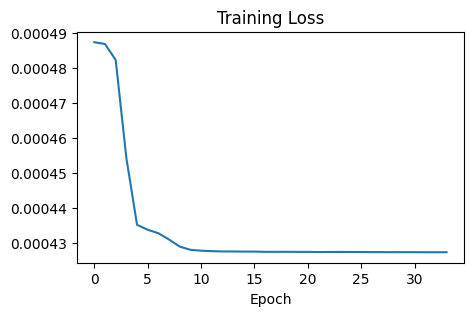

In [23]:
B = 1
input_dimension = X.shape[1]
OPT = Adam(learning_rate=1e-3)

autoencoder, encoder, decoder = autoencoder_model_gen(input_dimension, B, use_bias=False, extra_layers=True)
autoencoder.compile(optimizer=OPT, loss='mse')
autoencoder.summary()
autoencoder.fit(train_data, train_data, 
                epochs=100, 
                batch_size=16, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(5, 3))
plt.plot(autoencoder.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mean Squared Error: 0.0005055856838940952
R-Squared: 0.12065287100182065
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


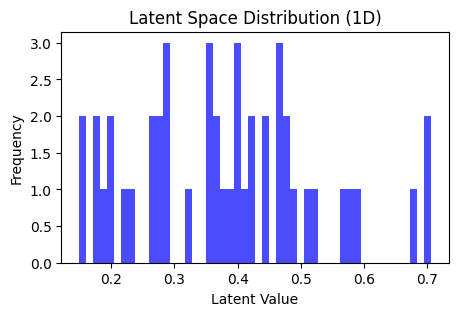

In [ ]:
def output_reconstruction_error (model, data, display = True):
    recoded_data = model.predict(data)
    mse = mean_squared_error(data, recoded_data)
    rsquared = 1 - mse/np.var(data)
    if display:
        print(f"Mean Squared Error: {mse}")
        print(f"R-Squared: {rsquared}")

output_reconstruction_error(autoencoder, test_data)
### Exploring the lantent space
latent_space = encoder.predict(test_data)
plt.figure(figsize=(5, 3))
plt.hist(latent_space, bins=50, color='blue', alpha=0.7)
plt.title("Latent Space Distribution (1D)")
plt.xlabel("Latent Value")
plt.ylabel("Frequency")
plt.show()


Sometimes, the latent space is just a constant. When this happens, is due that the model wasn't able to converge-learn.

#### 1.1.2 Creating sign accuracy function

The average fraction of the sign of the returns will be called the sign accuracy function. This function will be used to evaluate the performance of the autoencoder.

In [25]:
def compute_sign_accuracy (original, reconstructed):
    original_signs = np.sign(original)
    reconstructed_signs = np.sign(reconstructed)
    
    correct_signs = (original_signs == reconstructed_signs).astype(float)
    sign_accuracy = np.mean(correct_signs)
    return sign_accuracy
reconstructed_train = autoencoder.predict(train_data)
reconstructed_val = autoencoder.predict(val_data)
reconstructed_test = autoencoder.predict(test_data)

train_sign_accuracy = compute_sign_accuracy(train_data, reconstructed_train)
val_sign_accuracy = compute_sign_accuracy(val_data, reconstructed_val)
test_sign_accuracy = compute_sign_accuracy(test_data, reconstructed_test)

print(f"Sign Accuracy (Training): {train_sign_accuracy:.4f}")
print(f"Sign Accuracy (Validation): {val_sign_accuracy:.4f}")
print(f"Sign Accuracy (Test): {test_sign_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Sign Accuracy (Training): 0.2114
Sign Accuracy (Validation): 0.2097
Sign Accuracy (Test): 0.2113


From what we can see, we get around 20% of accuracy. This isn't a good result.

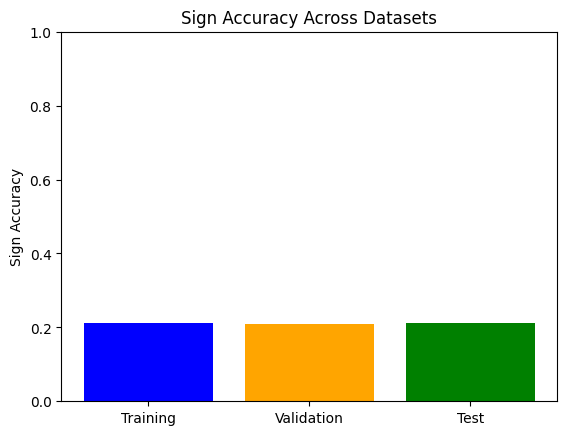

In [26]:
datasets = ['Training', 'Validation', 'Test']
accuracies = [train_sign_accuracy, val_sign_accuracy, test_sign_accuracy]

plt.bar(datasets, accuracies, color=['blue', 'orange', 'green'])
plt.title("Sign Accuracy Across Datasets")
plt.ylabel("Sign Accuracy")
plt.ylim(0, 1)
plt.show()


#### 1.1.3 Trace sign accuracy across different B values



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPl

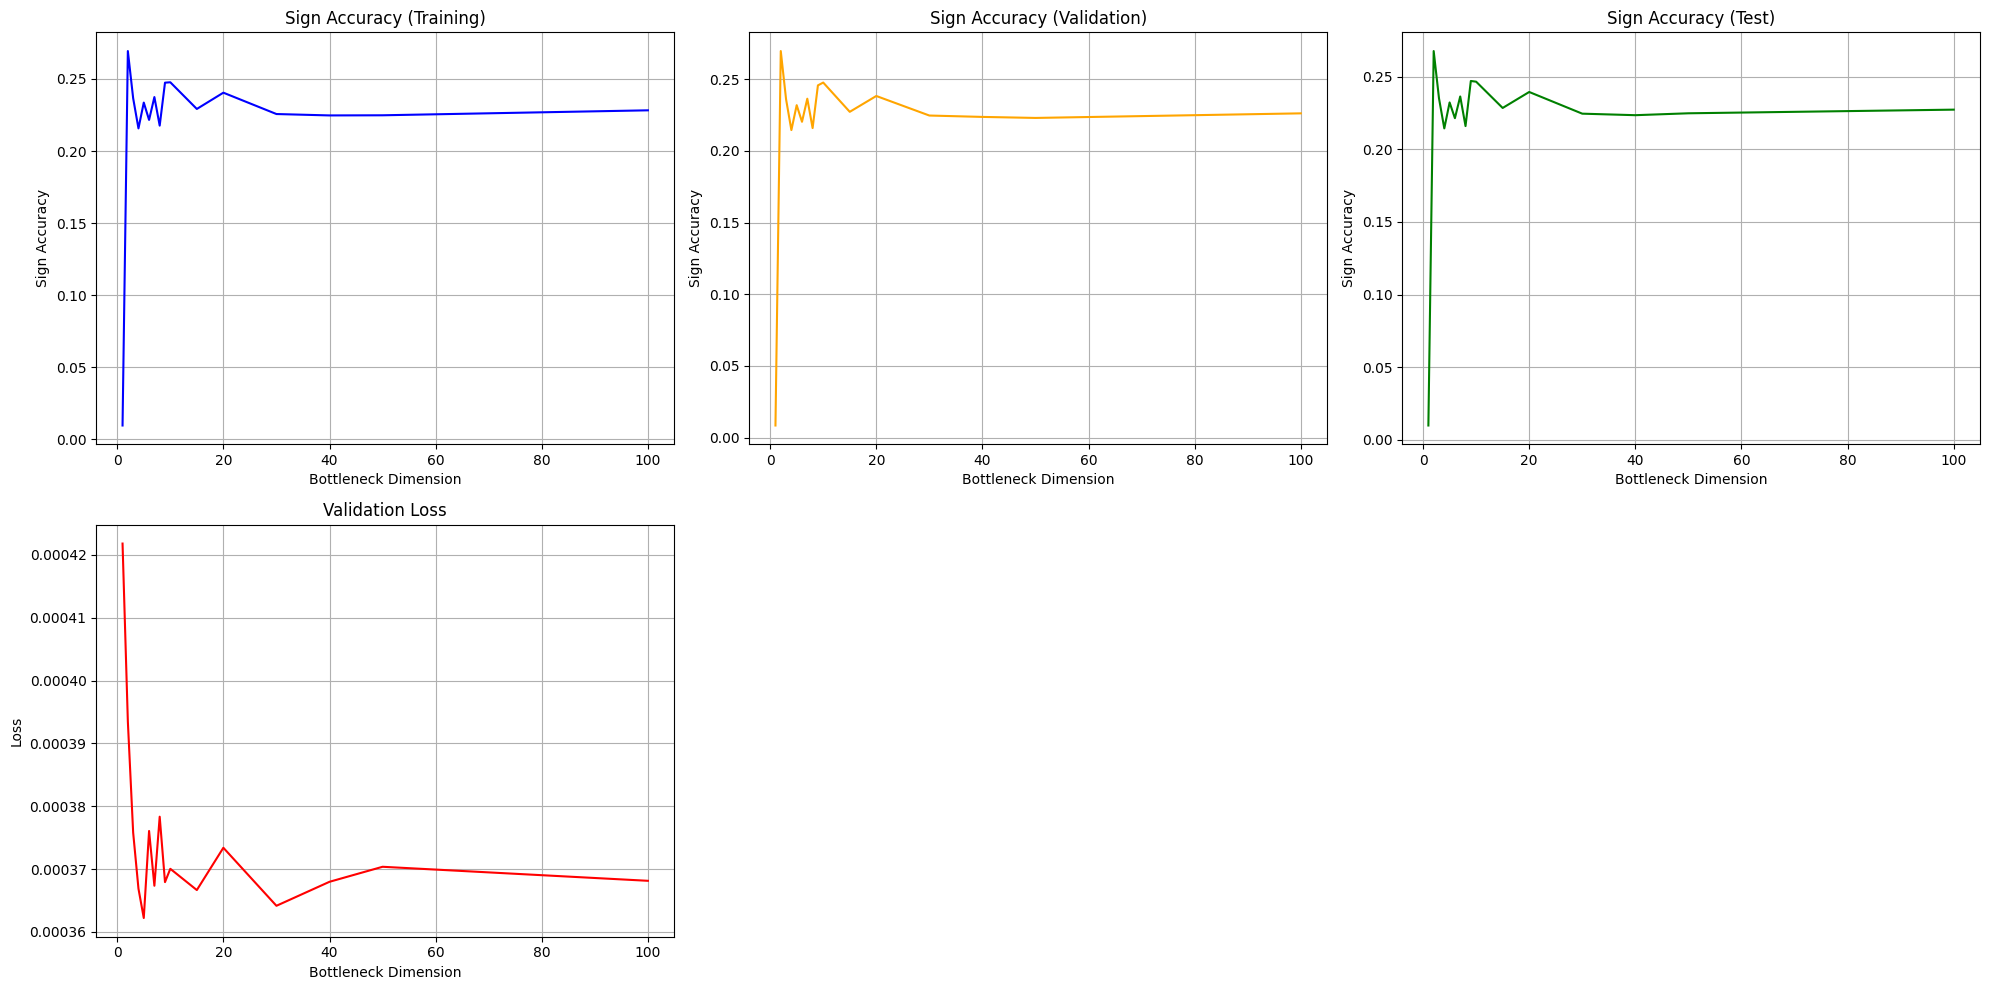

Best Bottleneck Dimension for Training Accuracy: 2


In [31]:
Bs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 100]
sign_accuracies_train = []
sign_accuracies_val = []
sign_accuracies_test = []
val_losses = []

for B in Bs:
    # Define and compile the model
    OPT = Adam(learning_rate=1e-3)
    autoencoder, encoder, decoder = autoencoder_model_gen(input_dimension, B, use_bias=False)
    autoencoder.compile(optimizer=OPT, loss='mse')

    # Train the model and store the validation loss
    history = autoencoder.fit(
        train_data, train_data,
        epochs=100,
        batch_size=32,
        validation_data=(val_data, val_data),
        callbacks=[lr_scheduler, es],
        verbose=0
    )
    val_losses.append(min(history.history['val_loss']))

    # Reconstruct data
    reconstructed_train = autoencoder.predict(train_data, verbose=0)
    reconstructed_val = autoencoder.predict(val_data, verbose=0)
    reconstructed_test = autoencoder.predict(test_data, verbose=0)

    # Compute sign accuracy
    sign_accuracies_train.append(compute_sign_accuracy(train_data, reconstructed_train))
    sign_accuracies_val.append(compute_sign_accuracy(val_data, reconstructed_val))
    sign_accuracies_test.append(compute_sign_accuracy(test_data, reconstructed_test))

# Plotting results
plt.figure(figsize=(20, 10))

# Sign Accuracy (Training)
plt.subplot(2, 3, 1)
plt.plot(Bs, sign_accuracies_train, label='Training', color='blue')
plt.title("Sign Accuracy (Training)")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Sign Accuracy")
plt.grid()

# Sign Accuracy (Validation)
plt.subplot(2, 3, 2)
plt.plot(Bs, sign_accuracies_val, label='Validation', color='orange')
plt.title("Sign Accuracy (Validation)")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Sign Accuracy")
plt.grid()

# Sign Accuracy (Test)
plt.subplot(2, 3, 3)
plt.plot(Bs, sign_accuracies_test, label='Test', color='green')
plt.title("Sign Accuracy (Test)")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Sign Accuracy")
plt.grid()

# Validation Loss
plt.subplot(2, 3, 4)
plt.plot(Bs, val_losses, label='Validation Loss', color='red')
plt.title("Validation Loss")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Loss")
plt.grid()

plt.tight_layout()
plt.show()

# Index of the highest value in training sign accuracy
index_of_highest_value = np.argmax(sign_accuracies_train)
print(f"Best Bottleneck Dimension for Training Accuracy: {Bs[index_of_highest_value]}")


We can see a very particular result here. The higher the dimension doesn't mean a better reconstruction of the data sign accuracy. At the end, the model will try to extract most of the useful information of the data and pass it through the bottle neck. Extra values will be discarded and considered as noise. If we add more dimensions we not needed, some noise might be captured.

Still, it is important to notice that all the sign accuracies have very close values between each other, so using a lower dimension bottle neck would be the best option, following the KISS principle.

#### Latent space in 2 dimensions


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.7527e-04 - val_loss: 3.9324e-04 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5347e-04 - val_loss: 3.7823e-04 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3284e-04 - val_loss: 3.7106e-04 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3538e-04 - val_loss: 3.6790e-04 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2554e-04 - val_loss: 3.6589e-04 - learning_rate: 0.0010
Epoch 6/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0506e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0954e-04 - val_loss: 3.6378e-04 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3910e-04 - val_loss: 3.6266e-04 - learning_rate: 5.0000e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step -

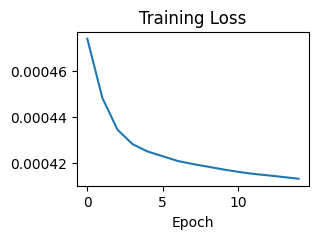

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


<Figure size 300x300 with 0 Axes>

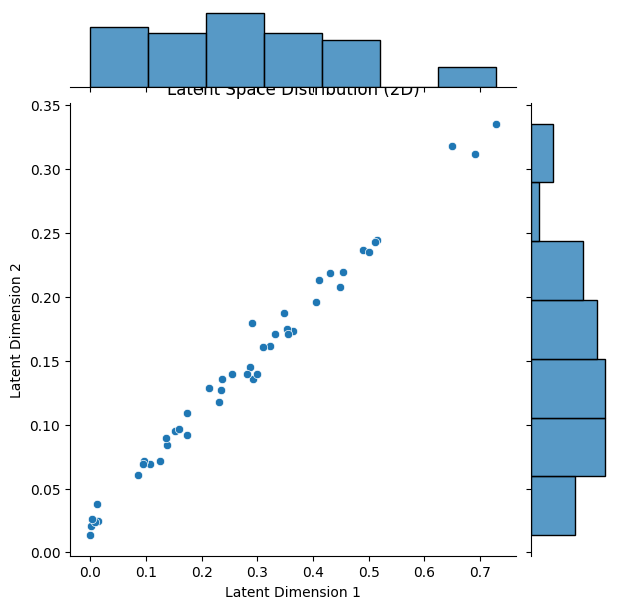

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Mean Squared Error: 0.0004935327220240829
R-Squared: 0.1416161572536917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Sign Accuracy (2D): 0.2641


In [ ]:
B = 2
OPT2 = Adam(learning_rate=1e-3)

autoencoder2, encoder2, decoder2 = autoencoder_model_gen(input_dimension, B)
autoencoder2.compile(optimizer=OPT2, loss='mse')
autoencoder2.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder2.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()

latent_space = encoder2.predict(test_data)
x, y = latent_space[:, 0], latent_space[:, 1]
plt.figure(figsize=(3, 3))
sns.jointplot(x=x, y=y, kind='scatter')
plt.title("Latent Space Distribution (2D)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

output_reconstruction_error(autoencoder2, test_data)
sign_accuracy_2d = compute_sign_accuracy(test_data, autoencoder2.predict(test_data))
print(f"Sign Accuracy (2D): {sign_accuracy_2d:.4f}")

We are using a two dimensional latent space representation. We can see that the sign accuracy is around 25%. This is a low value, but we already know that we cannot get a better result with a higher dimension latent space. We can also see a very particular pattern in the latent space. The dimension of the latent space can be reduced to a one dimensional space, since the data is very close to a line.

#### 3 dimensional latent space


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 4.8660e-04 - val_loss: 3.9147e-04 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.5778e-04 - val_loss: 3.7401e-04 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0675e-04 - val_loss: 3.6469e-04 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.3156e-04 - val_loss: 3.5988e-04 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2543e-04 - val_loss: 3.5784e-04 - learning_rate: 0.0010
Epoch 6/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5299e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4332e-04 - val_loss: 3.5683e-04 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.1721e-04 - val_loss: 3.5605e-04 - learning_rate: 5.0000e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step -

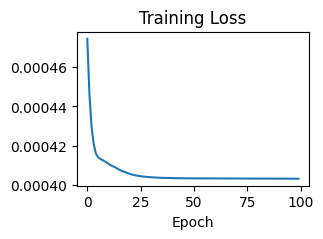

In [40]:
B = 3
OPT3 = Adam(learning_rate=1e-3)

autoencoder3, encoder3, decoder3 = autoencoder_model_gen(input_dimension, B)
autoencoder3.compile(optimizer=OPT3, loss='mse')
autoencoder3.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder3.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Mean Squared Error: 0.00048175598752125314
R-Squared: 0.16209901110800762
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Sign Accuracy: 0.2839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


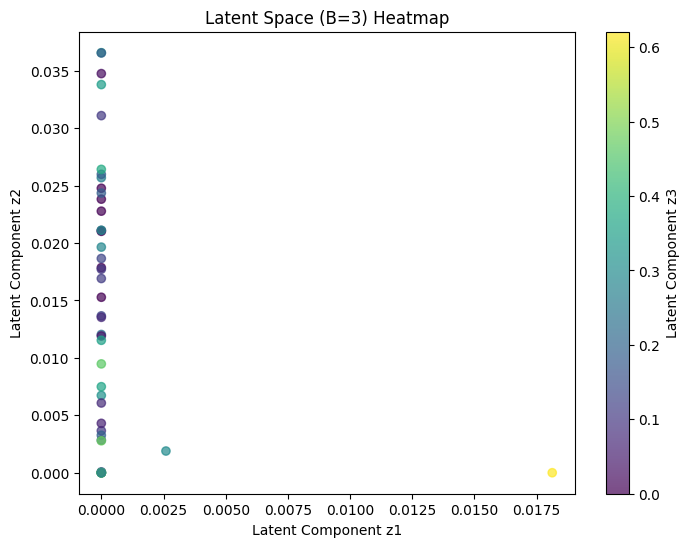

In [41]:
output_reconstruction_error(autoencoder3, test_data)
sign_accuracy = compute_sign_accuracy(test_data, autoencoder3.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")
latent_space = encoder3.predict(test_data)

latent_space = encoder3.predict(test_data) 

z1, z2, z3 = latent_space[:, 0], latent_space[:, 1], latent_space[:, 2]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z1, z2, c=z3, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Latent Component z3")
plt.title("Latent Space (B=3) Heatmap")
plt.xlabel("Latent Component z1")
plt.ylabel("Latent Component z2")
plt.show()


From what i can see, a two dimentional latent space can capture most of the information in the data, following th PCA analysis. 


When working with higher dimensional spaces, we are going to get the bottleneck values, and then pass the high dimensional values to a UMAP (Uniform Manifold Approximation and Projection), to reduce the dimension of the latent space to make it easier to visualize.

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.6433e-04 - val_loss: 3.9148e-04 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4553e-04 - val_loss: 3.7462e-04 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2315e-04 - val_loss: 3.6561e-04 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3723e-04 - val_loss: 3.6094e-04 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0281e-04 - val_loss: 3.5876e-04 - learning_rate: 0.0010
Epoch 6/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2759e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2473e-04 - val_loss: 3.5771e-04 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0677e-04 - val_loss: 3.5684e-04 - learning_rate: 5.0000e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step -

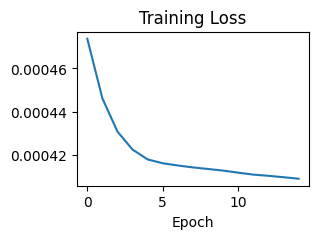

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Sign Accuracy: 0.2801


In [42]:
B = 4
OPT4 = Adam(learning_rate=1e-3)

autoencoder4, encoder4, decoder4 = autoencoder_model_gen(input_dimension, B)
autoencoder4.compile(optimizer=OPT4, loss='mse')
autoencoder4.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder4.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()

sign_accuracy = compute_sign_accuracy(test_data, autoencoder4.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")


Sign accuracy of 28%, which is getting higher.

c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


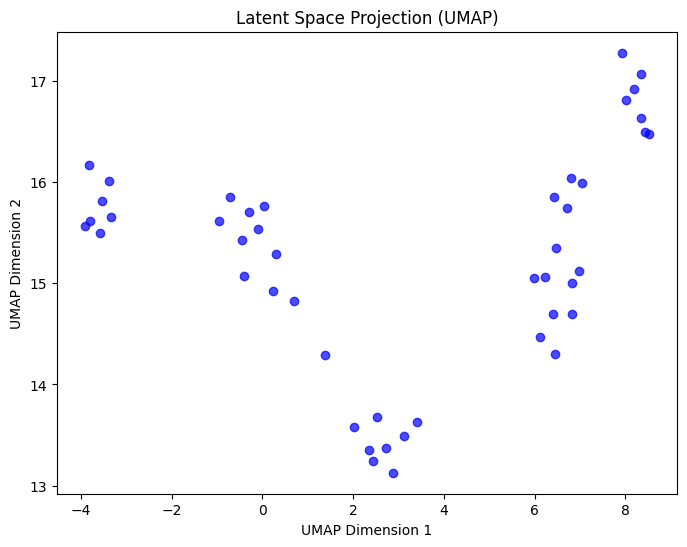

In [43]:
import umap.umap_ as umap
latent_space = encoder4.predict(test_data)
reducer = umap.UMAP(n_components=2)
latent_2d = reducer.fit_transform(latent_space)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.7)
plt.title("Latent Space Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


We can see some clusters, proving that the UMAP is working correctly, preserving the local structure of the data.

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.8108e-04 - val_loss: 3.9389e-04 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.5024e-04 - val_loss: 3.7857e-04 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2673e-04 - val_loss: 3.7106e-04 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.1869e-04 - val_loss: 3.6666e-04 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3901e-04 - val_loss: 3.6345e-04 - learning_rate: 0.0010
Epoch 6/100
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7647e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.9266e-04 - val_loss: 3.6120e-04 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.1270e-04 - val_loss: 3.6016e-04 - learning_rate: 5.0000e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step -

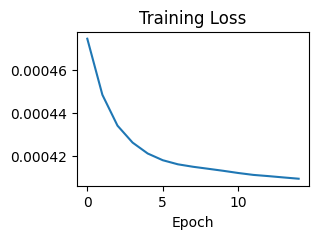

In [44]:
B = 5
OPT5 = Adam(learning_rate=1e-3)

autoencoder5, encoder5, decoder5 = autoencoder_model_gen(input_dimension, B)
autoencoder5.compile(optimizer=OPT5, loss='mse')
autoencoder5.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder5.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Sign Accuracy: 0.2764
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


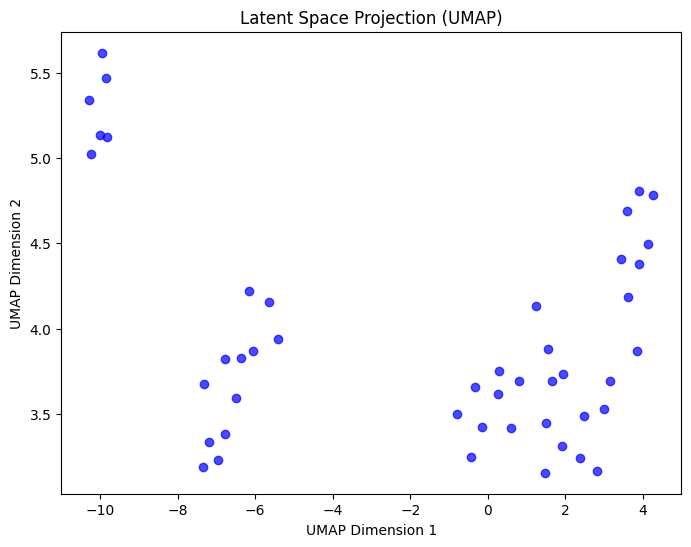

In [46]:
sign_accuracy = compute_sign_accuracy(test_data, autoencoder5.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")
latent_space = encoder5.predict(test_data)
reducer = umap.UMAP(n_components=2)
latent_2d = reducer.fit_transform(latent_space)

# Plot the 2D projection
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.7)
plt.title("Latent Space Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


An acuraccy of 27%, which didn't improve the previous result, but we can get some nice clusters of the data.

---

## 2. Markets states

### 2.1  


In [47]:
X = data_clean
X.shape
train_data, temp_data = train_test_split(X, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")


Train data shape: (2201, 301)
Validation data shape: (472, 301)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 301)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_3 (Dense)         │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_4 (Dense)         │ (None, 32)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 1)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_3 (Dense)         │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_4 (Dense)         │ (None, 256)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 301)            │        77,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,192 (938.25 KB)

 Trainable params: 240,192 (938.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.9195e-04 - val_loss: 4.2921e-04 - learning_rate: 0.0010
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5577e-04 - val_loss: 4.2373e-04 - learning_rate: 0.0010
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7357e-04 - val_loss: 4.2632e-04 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2580e-04 - val_loss: 4.2341e-04 - learning_rate: 0.0010
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2521e-04 - val_loss: 4.2332e-04 - learning_rate: 0.0010
Epoch 6/100
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4170e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4156e-04 - val_loss: 4.2207e-04 - learning_rate: 0.0010
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1880e-04 - val_loss: 4.2138e-04 - learning_rate: 5.0000e-04
Epoch 8/100
138/138 ━━━━━━━

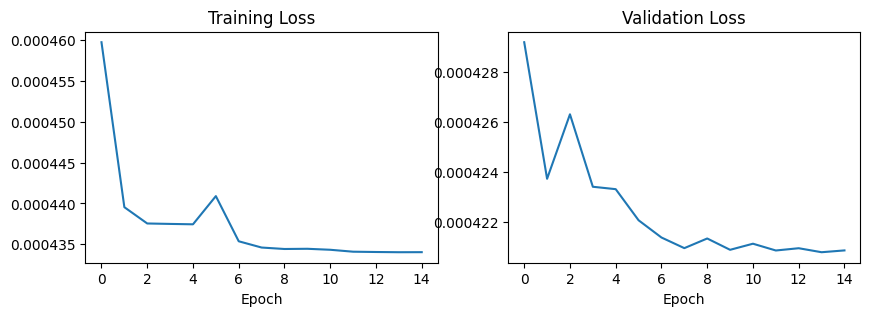

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


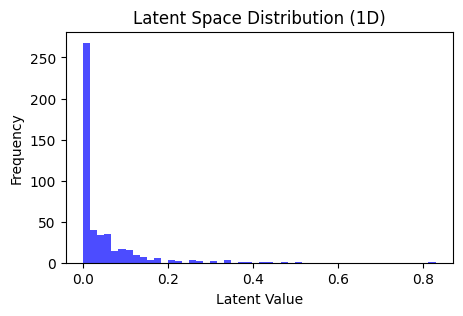

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error: 0.0004228041493490179
R-Squared: A      -0.072050
AABA    0.077301
ABC    -1.425810
ABT    -2.375415
ADBE   -0.008642
          ...   
XOM    -1.299466
XRX     0.025306
YUM    -0.469535
ZBH    -0.863778
ZION    0.730558
Length: 301, dtype: float64
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sign Accuracy: 0.2334


c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [51]:
B = 1
input_dimension = X.shape[1]
OPT = Adam(learning_rate=1e-3)

autoencoder, encoder, decoder = autoencoder_model_gen(input_dimension, B, use_bias=False)
autoencoder.compile(optimizer=OPT, loss='mse')
autoencoder.summary()
history = autoencoder.fit(train_data, train_data, 
                epochs=100, 
                batch_size=16, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='validation')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.show()
latent_space = encoder.predict(test_data)
plt.figure(figsize=(5, 3))
plt.hist(latent_space, bins=50, color='blue', alpha=0.7)
plt.title("Latent Space Distribution (1D)")
plt.xlabel("Latent Value")
plt.ylabel("Frequency")
plt.show()

output_reconstruction_error(autoencoder, test_data)
sign_accuracy = compute_sign_accuracy(test_data, autoencoder.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")

Sign Accuracy of 23%


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlate

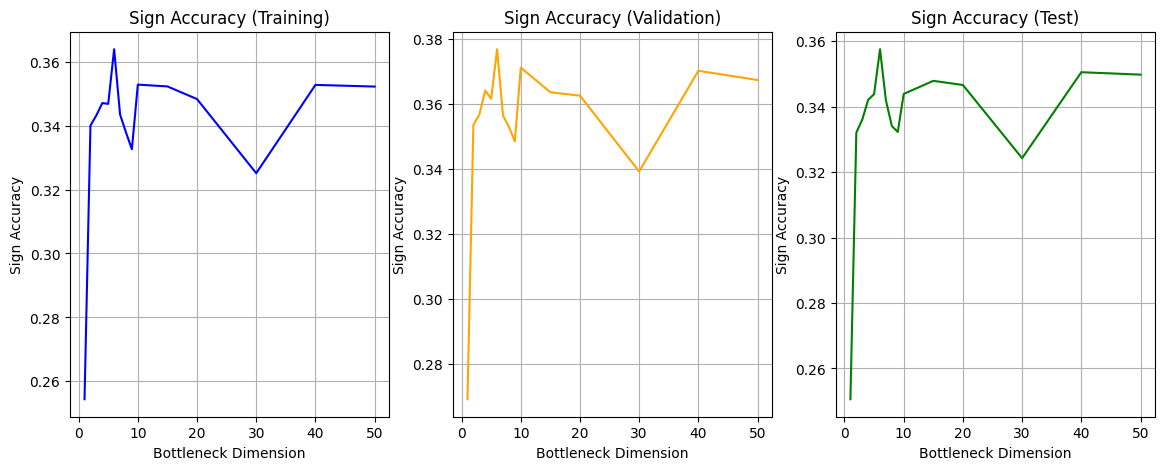

Index of the highest value in sign_accuracies_train: 6


In [49]:
Bs = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50]
sign_accuracies_train = []
sign_accuracies_val = []
sign_accuracies_test = []

for B in Bs:
    OPT = Adam(learning_rate=1e-3)
    autoencoder, encoder, decoder = autoencoder_model_gen(input_dimension, B, use_bias=False)
    autoencoder.compile(optimizer=OPT, loss='mse')
    autoencoder.fit(train_data, train_data, 
                    epochs=100, 
                    batch_size=16, 
                    validation_data=(val_data, val_data),
                    callbacks=[lr_scheduler, es],
                    verbose=0
    )
    
    reconstructed_train = autoencoder.predict(train_data)
    reconstructed_val = autoencoder.predict(val_data)
    reconstructed_test = autoencoder.predict(test_data)
    
    train_sign_accuracy = compute_sign_accuracy(train_data, reconstructed_train)
    val_sign_accuracy = compute_sign_accuracy(val_data, reconstructed_val)
    test_sign_accuracy = compute_sign_accuracy(test_data, reconstructed_test)
    
    sign_accuracies_train.append(train_sign_accuracy)
    sign_accuracies_val.append(val_sign_accuracy)
    sign_accuracies_test.append(test_sign_accuracy)
plt.figure(figsize=(14, 5))
plt.subplot(1,3, 1)
plt.plot(Bs, sign_accuracies_train, label='Training', color='blue')
plt.title("Sign Accuracy (Training)")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Sign Accuracy")
plt.grid()
plt.subplot(1,3, 2)
plt.plot(Bs, sign_accuracies_val, label='Validation', color='orange')
plt.title("Sign Accuracy (Validation)")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Sign Accuracy")
plt.grid()
plt.subplot(1,3, 3)
plt.plot(Bs, sign_accuracies_test, label='Test', color='green')
plt.title("Sign Accuracy (Test)")
plt.xlabel("Bottleneck Dimension")
plt.ylabel("Sign Accuracy")
plt.grid()
plt.show()
index_of_highest_value = np.argmax(sign_accuracies_train)
print(f"Index of the highest value in sign_accuracies_train: {Bs[index_of_highest_value]}")


Again, we can see that higher dimensions doesn't provide the best results around the sign accuracy. The highest value is 6 in this case.

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.6606e-04 - val_loss: 4.3144e-04 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4301e-04 - val_loss: 4.3089e-04 - learning_rate: 0.0010
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1673e-04 - val_loss: 4.2762e-04 - learning_rate: 0.0010
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6959e-04 - val_loss: 4.2716e-04 - learning_rate: 0.0010
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3625e-04 - val_loss: 4.2705e-04 - learning_rate: 0.0010
Epoch 6/100
65/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4077e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4068e-04 - val_loss: 4.2692e-04 - learning_rate: 0.0010
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9957e-04 - val_loss: 4.2547e-04 - learning_rate: 5.0000e-04
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3

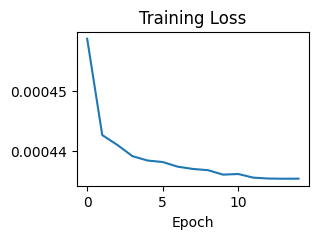

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 300x300 with 0 Axes>

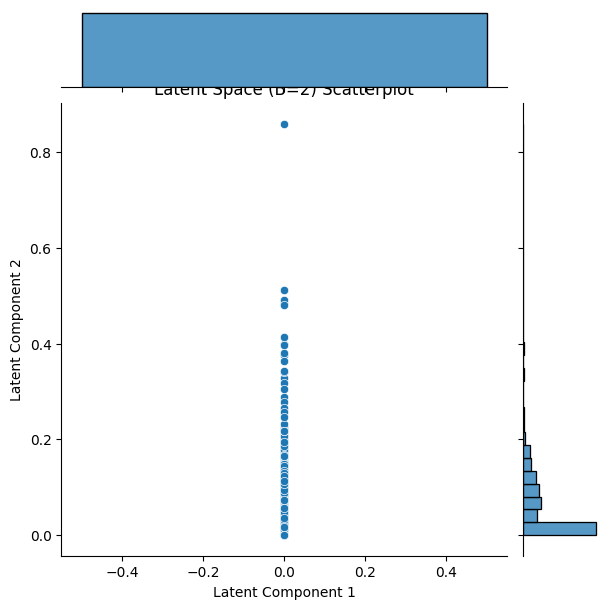

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error: 0.0004282497691657259
R-Squared: A      -0.085858
AABA    0.065416
ABC    -1.457054
ABT    -2.418890
ADBE   -0.021633
          ...   
XOM    -1.329083
XRX     0.012752
YUM    -0.488463
ZBH    -0.887783
ZION    0.727088
Length: 301, dtype: float64
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sign Accuracy: 0.2155


c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [53]:
B = 2
OPT2 = Adam(learning_rate=1e-3)

autoencoder2, encoder2, decoder2 = autoencoder_model_gen(input_dimension, B)
autoencoder2.compile(optimizer=OPT2, loss='mse')
autoencoder2.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder2.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()

latent_space = encoder2.predict(test_data)
x, y = latent_space[:, 0], latent_space[:, 1]
plt.figure(figsize=(3, 3))
sns.jointplot(x=x, y=y, kind='scatter')
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
plt.title("Latent Space (B=2) Scatterplot")
plt.show()

output_reconstruction_error(autoencoder2, test_data)
sign_accuracy = compute_sign_accuracy(test_data, autoencoder2.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")

Literally, the model is one dimensional, which means that sometimes the model converge to a lower dimension being more efficient at capturing the data.

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.9184e-04 - val_loss: 4.3608e-04 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4689e-04 - val_loss: 4.3403e-04 - learning_rate: 0.0010
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4335e-04 - val_loss: 4.2983e-04 - learning_rate: 0.0010
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6238e-04 - val_loss: 4.2874e-04 - learning_rate: 0.0010
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5309e-04 - val_loss: 4.2941e-04 - learning_rate: 0.0010
Epoch 6/100
49/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4504e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4569e-04 - val_loss: 4.2838e-04 - learning_rate: 0.0010
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3928e-04 - val_loss: 4.2706e-04 - learning_rate: 5.0000e-04
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3

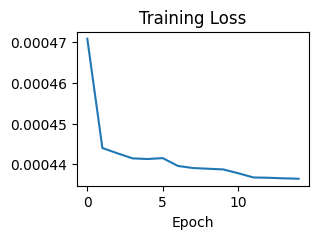

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Squared Error: 0.00042693414745119347
R-Squared: A      -0.082522
AABA    0.068287
ABC    -1.449505
ABT    -2.408387
ADBE   -0.018494
          ...   
XOM    -1.321928
XRX     0.015785
YUM    -0.483890
ZBH    -0.881984
ZION    0.727926
Length: 301, dtype: float64
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sign Accuracy: 0.2050


c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [54]:
B = 3
OPT3 = Adam(learning_rate=1e-3)

autoencoder3, encoder3, decoder3 = autoencoder_model_gen(input_dimension, B)
autoencoder3.compile(optimizer=OPT3, loss='mse')
autoencoder3.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder3.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()

output_reconstruction_error(autoencoder3, test_data)
sign_accuracy = compute_sign_accuracy(test_data, autoencoder3.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


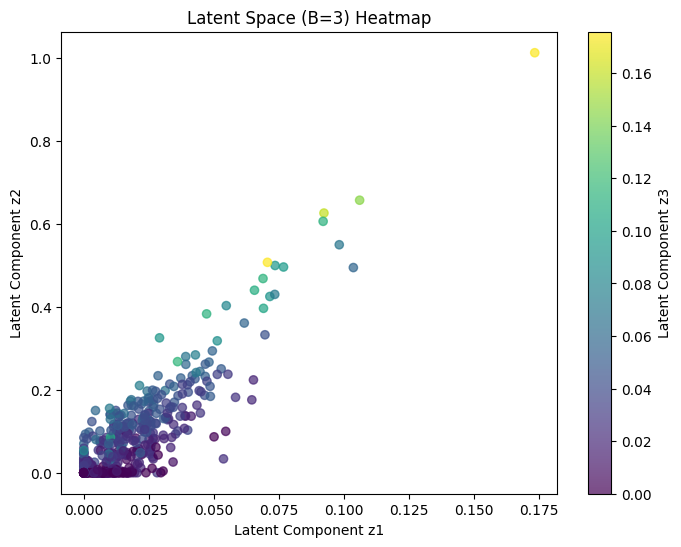

In [57]:
latent_space = encoder3.predict(test_data)
z1, z2, z3 = latent_space[:, 0], latent_space[:, 1], latent_space[:, 2]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z1, z2, c=z3, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Latent Component z3")
plt.title("Latent Space (B=3) Heatmap")
plt.xlabel("Latent Component z1")
plt.ylabel("Latent Component z2")
plt.show()

Here we can see that the model is using the three dimensions, but following a PCA approach, the that is almost two dimensional.


Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.8693e-04 - val_loss: 4.2669e-04 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2664e-04 - val_loss: 4.2443e-04 - learning_rate: 0.0010
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2193e-04 - val_loss: 4.2308e-04 - learning_rate: 0.0010
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1968e-04 - val_loss: 4.2134e-04 - learning_rate: 0.0010
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4871e-04 - val_loss: 4.1431e-04 - learning_rate: 0.0010
Epoch 6/100
45/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2918e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2808e-04 - val_loss: 4.1114e-04 - learning_rate: 0.0010
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1825e-04 - val_loss: 4.0662e-04 - learning_rate: 5.0000e-04
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3

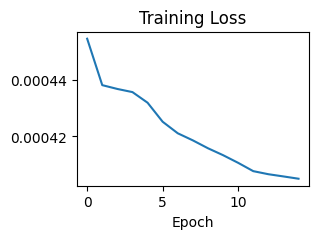

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error: 0.0003953704084270052
R-Squared: A      -0.002490
AABA    0.137170
ABC    -1.268411
ABT    -2.156401
ADBE    0.056804
          ...   
XOM    -1.150265
XRX     0.088549
YUM    -0.374184
ZBH    -0.742847
ZION    0.748041
Length: 301, dtype: float64
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sign Accuracy: 0.2682


c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [61]:
B = 6
OPT4 = Adam(learning_rate=1e-3)

autoencoder4, encoder4, decoder4 = autoencoder_model_gen(input_dimension, B)
autoencoder4.compile(optimizer=OPT4, loss='mse')
autoencoder4.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es]
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder4.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()
latent_space = encoder4.predict(test_data)
reducer = umap.UMAP(n_components=2)
latent_2d = reducer.fit_transform(latent_space)

output_reconstruction_error(autoencoder4, test_data)
sign_accuracy = compute_sign_accuracy(test_data, autoencoder4.predict(test_data))
print(f"Sign Accuracy: {sign_accuracy:.4f}")

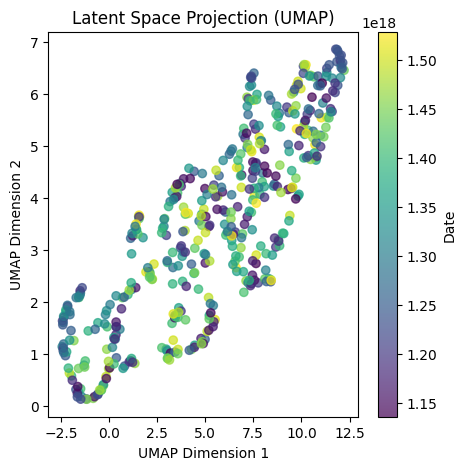

In [62]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_data.index, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label('Date')
plt.title("Latent Space Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


### 2.2 Prediction et performance

How can we use the AE for prediction? 

- We could search for clusters in the latent space and search for similarities within each cluster or pattern, so then we could predict makert state given the condition of the cluster being fulfilled.
- Another way to understand the latent space would be to think of AE as a dimension reduction. This latent space has the essential information inside of the data extracted. We could try to make a time series with this information, to see if we can predict the future states of the market using a less noisy dataset.

How to judge the performance? 

- We could use the accuracy of the sign of the returns, as we did before. This would be a good way to see if the model is capturing the trends of the market.
- Another measure more basic and naive would be to use the mean squared error and $R^2$. This would be a good way to see if the model is able to predict the returns of the market. 

---

## 3. Anomaly detection

### 3.1 

Plot the average reconstruction error of securities over time (daily average). Which days have abnormal reconstruction error? Can you relate these days to another market characteristic?
X = data_clean


In [96]:
input_dimension = data_clean.shape[1]

train_data, temp_data = train_test_split(data_clean, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

We are going to use a two dimensional model, since is the simplest that extract most of the information and the one that we can graphically interpret.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping


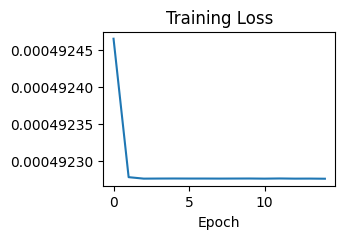

In [97]:
B = 2
OPT2 = Adam(learning_rate=1e-3)

autoencoder2, encoder2, decoder2 = autoencoder_model_gen(input_dimension, B)
autoencoder2.compile(optimizer=OPT2, loss='mse')
autoencoder2.fit(train_data, train_data, 
                epochs=100, 
                batch_size=32, 
                validation_data=(val_data, val_data),
                callbacks=[lr_scheduler, es],
                verbose=0
)
plt.figure(figsize=(3, 2))
plt.plot(autoencoder2.history.history['loss'], label='train')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.show()


Sign Accuracy: 0.2155
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Squared Error: 0.0004897106951792072
R-Squared: A      -0.241697
AABA   -0.068712
ABC    -1.809682
ABT    -2.909557
ADBE   -0.168254
          ...   
XOM    -1.663345
XRX    -0.128935
YUM    -0.702082
ZBH    -1.158712
ZION    0.687921
Length: 301, dtype: float64
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


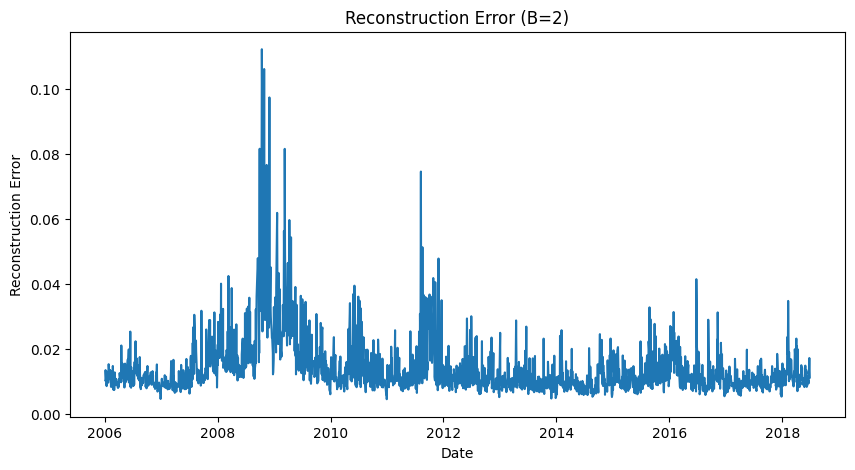

In [98]:
sign_accuracy = compute_sign_accuracy(train_data.sort_index(), reconstructed_train)
print(f"Sign Accuracy: {sign_accuracy:.4f}")
output_reconstruction_error(autoencoder2, test_data)
reconstructed_train = autoencoder2.predict(train_data.sort_index())
error = np.mean( np.abs(train_data.sort_index() - reconstructed_train) , axis = 1)
error = error.sort_index()
plt.figure(figsize=(10, 5))
plt.plot(error.index, error)
plt.title("Reconstruction Error (B=2)")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.show()


From the graph, we can see that the biggest error are between 2008 and 2011. This is the period of the finantial crisis. This means that the model can capture normal market conditions. This is expected, since the model is trying to reduce the dimension of the market and crisis are atypical conditions, anomalies, so the autoencoder might regard as this data as noisy, therefore the reconstruction error is higher.

Lets add some important dates of the financial crisis to the graph to see if we are correct in our analysis.

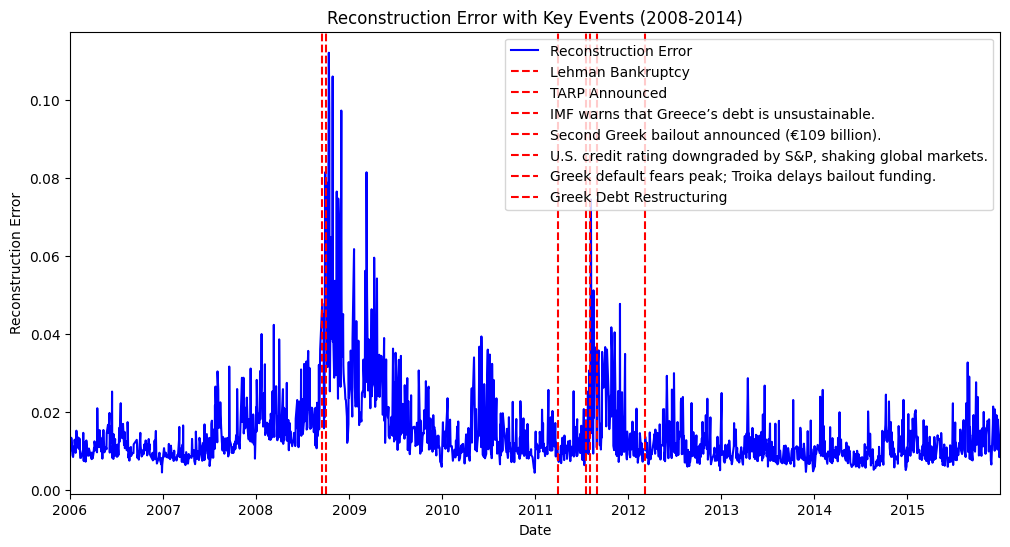

In [99]:
event_dates = {
    "Lehman Bankruptcy": "2008-09-15",
    "TARP Announced": "2008-10-03",
    "IMF warns that Greece’s debt is unsustainable." : "2011-04-01", 
    "Second Greek bailout announced (€109 billion)." : "2011-07-21",
    "U.S. credit rating downgraded by S&P, shaking global markets." : "2011-08-05",
    "Greek default fears peak; Troika delays bailout funding." : "2011-09-01",
    "Greek Debt Restructuring": "2012-03-09",
}


plt.figure(figsize=(12, 6))
plt.plot(error.index, np.abs(error), label="Reconstruction Error", color="blue")

#adding important dates to the graph
for event, date in event_dates.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label=event)

plt.title("Reconstruction Error with Key Events (2008-2014)")
plt.xlabel("Date")
plt.xlim(pd.to_datetime("2006-01-01"), pd.to_datetime("2015-12-31"))
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


From the graph we can also see the effect of the eurozone sovereign debt crisis (Greece debt) and the crisis subprime mortgage crisis. Both had a big impact in the market, and the model is not able to capture this information as it is not normal market conditions.

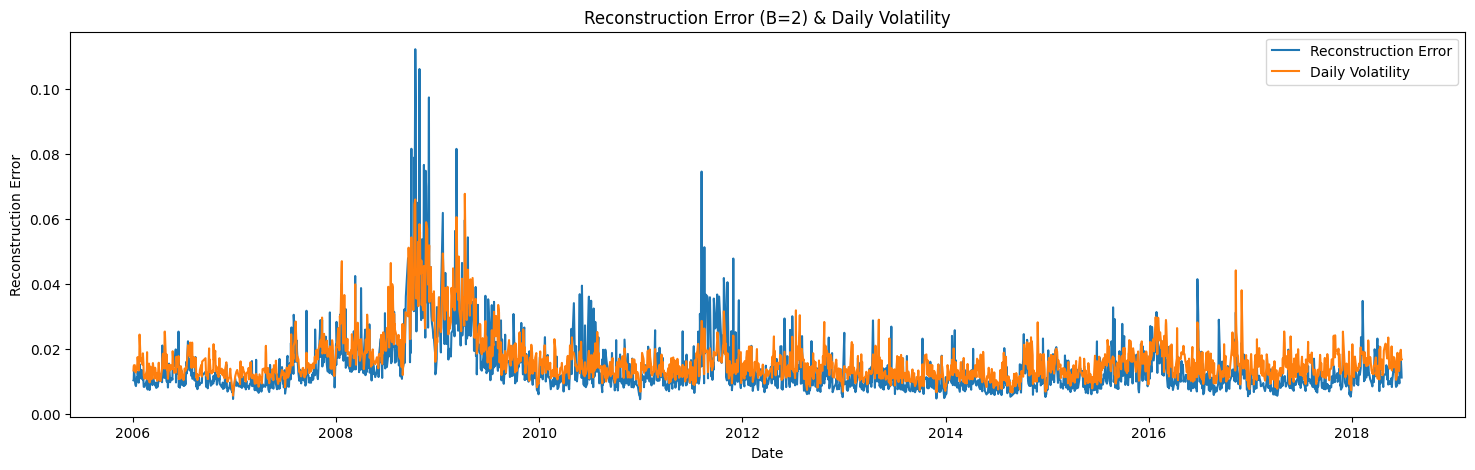

In [100]:
daily_volatility = train_data.sort_index().std(axis=1)
daily_mean = train_data.sort_index().mean(axis=1)
plt.figure(figsize=(18, 5))
plt.plot(error.index, np.abs(error), label="Reconstruction Error")
plt.plot(daily_volatility.index, daily_volatility, label="Daily Volatility")
plt.title("Reconstruction Error (B=2) & Daily Volatility")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


From the graphs we can see that there is a correlation between the reconstruction error and the volatility. From this we can conclude that the model is not capable to reconstruct when the market is uncertain, which makes sense since in this periods the market is very erratic.

The idea of volatility being correlated to the error is the same as the one explained previously. The anomalies aren't being captured by the model since they are considered as noise.

In [101]:
from scipy.stats import pearsonr, spearmanr

value =  np.corrcoef(np.abs(error), daily_volatility)[0,1]
print("Correlation between reconstruction error and the volatility: ", value)
spearmanr(np.abs(error), daily_volatility)


Correlation between reconstruction error and the volatility:  0.7981274208982946


SignificanceResult(statistic=np.float64(0.7617533206301503), pvalue=np.float64(0.0))

A very high correlation value, corroborating the previous analysis.

In [102]:
def compute_daily_sign_accuracy (original, reconstructed):
    original_signs = np.sign(original)
    reconstructed_signs = np.sign(reconstructed)
    
    correct_signs = (original_signs == reconstructed_signs).astype(float)
    sign_accuracy = np.mean(correct_signs, axis = 1)
    return sign_accuracy
compute_sign_accuracy(test_data.sort_index(), autoencoder2.predict(test_data.sort_index()))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


np.float64(0.009502224224336955)

In [103]:
daily_sign_accuracy = compute_daily_sign_accuracy(train_data.sort_index(), reconstructed_train)
daily_sign_trend = np.sign(train_data.sort_index()).mean(axis=1)
daily_sign_trend

index
2006-01-04    0.332226
2006-01-05   -0.083056
2006-01-06    0.621262
2006-01-09    0.315615
2006-01-10   -0.076412
                ...   
2018-06-21   -0.435216
2018-06-22    0.282392
2018-06-25   -0.534884
2018-06-27   -0.554817
2018-06-28    0.305648
Length: 2201, dtype: float64

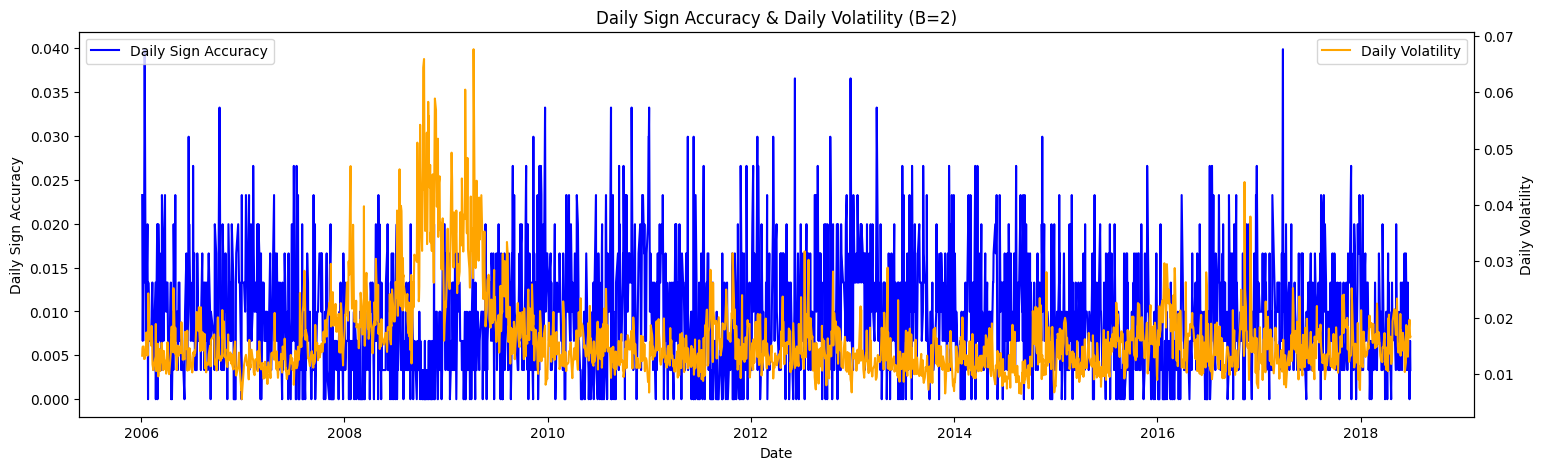

In [104]:
fig, ax1 = plt.subplots(figsize=(18, 5))
ax1.plot(daily_sign_accuracy.index, daily_sign_accuracy, label="Daily Sign Accuracy", color='b')
ax1.set_ylabel("Daily Sign Accuracy")
ax1.set_xlabel("Date")

ax2 = ax1.twinx()
ax2.plot(daily_volatility.index, daily_volatility, label="Daily Volatility", color='orange')
ax2.set_ylabel("Daily Volatility")

plt.title("Daily Sign Accuracy & Daily Volatility (B=2)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


From this graph, we can see that the volatility has low to no correlation with the trend detection of the model.
We will check the correlation between the reconstruction error and the volatility.


In [105]:
print("Correlation between reconstruction error and the volatility: ", np.corrcoef(daily_sign_accuracy, daily_volatility)[0,1] )
spearmanr(daily_volatility, daily_sign_accuracy)

Correlation between reconstruction error and the volatility:  -0.27377648285145156


SignificanceResult(statistic=np.float64(-0.30174754086755173), pvalue=np.float64(1.4557290999161562e-47))

No correlation at all

From the analysis done before, we can conclude that the volatility is highly correlated to the error of the model. This is because the model is not able to capture the anomalies in the market, which are the periods of high volatility. Therefore, the model is most useful only when the market conditions are stable.

### 3.2 

Calculate the average error of reconstruction of titles and classify them.  

In [106]:
mean_by_asset = np.mean( np.abs(train_data - reconstructed_train), axis = 0)
mean_by_asset = mean_by_asset.sort_values(ascending=True)

Text(0.5, 1.0, 'Mean Reconstruction Error by Asset')

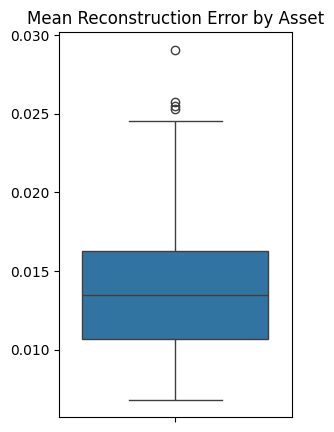

In [107]:
plt.figure(figsize=(3, 5))
sns.boxplot(mean_by_asset)
plt.title("Mean Reconstruction Error by Asset")

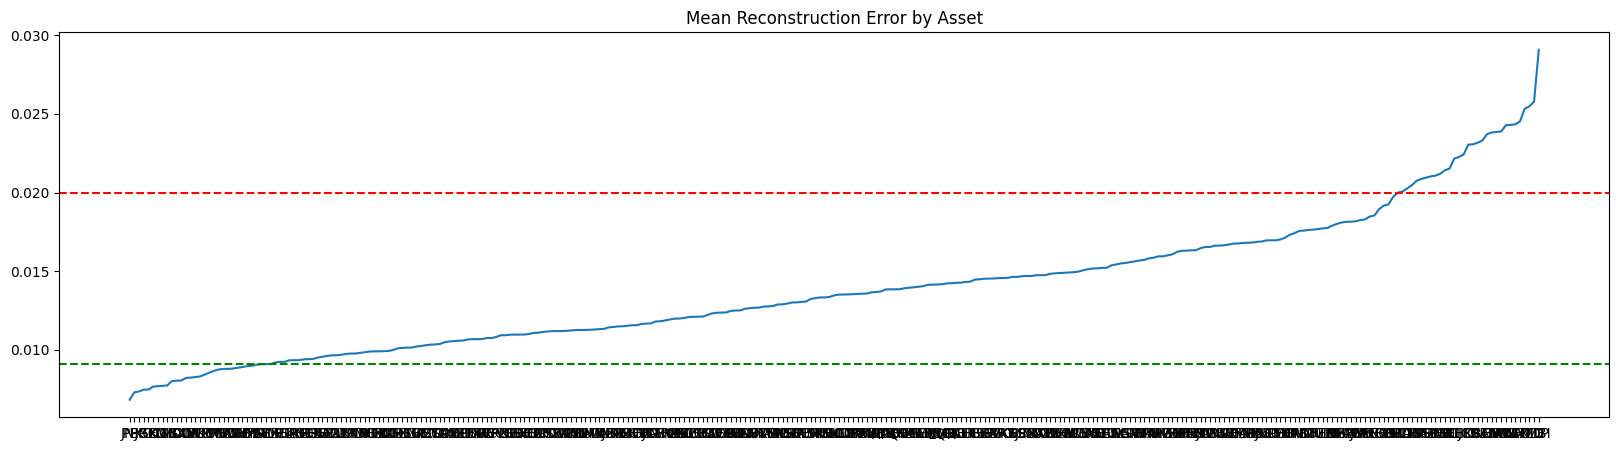

In [108]:
low_threshold = np.percentile(mean_by_asset, 10)   
high_threshold = np.percentile(mean_by_asset, 90)  
plt.figure(figsize=(20, 5))
plt.plot(mean_by_asset.index, mean_by_asset)
plt.title("Mean Reconstruction Error by Asset")
plt.axhline(low_threshold, color="green", linestyle="--", label="Low Threshold (10th Percentile)")
plt.axhline(high_threshold, color="red", linestyle="--", label="High Threshold (90th Percentile)")


We can see that the error doesnt increase at a constant rate. This can be interpreted as the model having more dificulties to caputure anormalities. That is why for most assets they have an error that is pretty similar, but for some few, they are pretty high.

So we can classify the assets in three groups. The ones that the model predict the best, which are ones belonging to percentile lower than 10. Then, we have most of the assets, where the prediction error doesn't vary greatly between assets. And finally, we have the assets that the model has more difficulties to predict, which are the ones that have an error higher than the 90th percentile.

Now, we will check the outliers that we detected in the boxplot. These are the ones in the 95th percentile and we will consider them the abnormal ones.

#### Outliers

In [109]:
q1 = np.quantile(mean_by_asset, 0.25)
q3 = np.quantile(mean_by_asset, 0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5*iqr
outliers = np.where(mean_by_asset > upper_bound)[0]
print("Amount of outleirs", len(outliers))
mean_by_asset.iloc[outliers].index

Amount of outleirs 4


Index(['SHLD', 'AMD', 'ODP', 'MBI'], dtype='object')

The assets with abnormal errors are AMD, SHLD, ODP, and MBI.

These industries have been significantly impacted by external factors. For instance:

- AMD, a technology firm, is highly influenced by international market conditions, commodity prices, and the political climate.
- SHLD operates in the retail sector, which is particularly vulnerable during economic downturns, as consumers tend to prioritize essential goods over discretionary spending.
- ODP and MBI are also companies that provide non-essential products and services, making them among the first to feel the effects of an economic crisis.